In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor
)
from sklearn.metrics import accuracy_score, mean_squared_error
from utils.helper import load_and_summarize, scale_dataframe, split_data

In [2]:
df_liver= load_and_summarize('CSV Files/liver_patient.csv')

--- Loading liver_patient.csv ---
First 5 rows:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  


In [3]:
df_liver = df_liver.drop('Gender', axis=1)
df_liver.dropna(inplace=True)

In [4]:
df_liver['Dataset'] = df_liver['Dataset'].replace(2, 0)

In [5]:
df_liver_scaled = scale_dataframe(df_liver)

In [6]:
X_train, X_test, y_train, y_test = split_data(df_liver_scaled,'Dataset')

## Baseline Model Performance 

### Logistic Regression

In [7]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(f"Baseline Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")

Baseline Logistic Regression Accuracy: 0.6293


### Decision Tree

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(f"Baseline Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")

Baseline Decision Tree Accuracy: 0.6466


## Bagging and Pasting Classifiers

### Bagging Classifier

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=100, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print(f"\nBagging Classifier Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}")


Bagging Classifier Accuracy: 0.6379


###  Pasting Classifier (Bagging with bootstrap=False) 

In [10]:
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=100, 
    bootstrap=False, 
    random_state=42
)
paste_clf.fit(X_train, y_train)
y_pred_paste = paste_clf.predict(X_test)
print(f"Pasting Classifier Accuracy: {accuracy_score(y_test, y_pred_paste):.4f}")

Pasting Classifier Accuracy: 0.6121


## Random Forest Classifier

In [11]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_features="sqrt")
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"\nRandom Forest Classifier Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")


Random Forest Classifier Accuracy: 0.6379


## Feature Importances 
#### A key benefit of Random Forests is the ability to see which features were most important.

In [12]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importances)


Feature Importances from Random Forest:
Alkaline_Phosphotase          0.165065
Alamine_Aminotransferase      0.140552
Age                           0.129100
Aspartate_Aminotransferase    0.126626
Total_Bilirubin               0.099318
Albumin                       0.091555
Total_Protiens                0.089558
Direct_Bilirubin              0.088703
Albumin_and_Globulin_Ratio    0.069523
dtype: float64


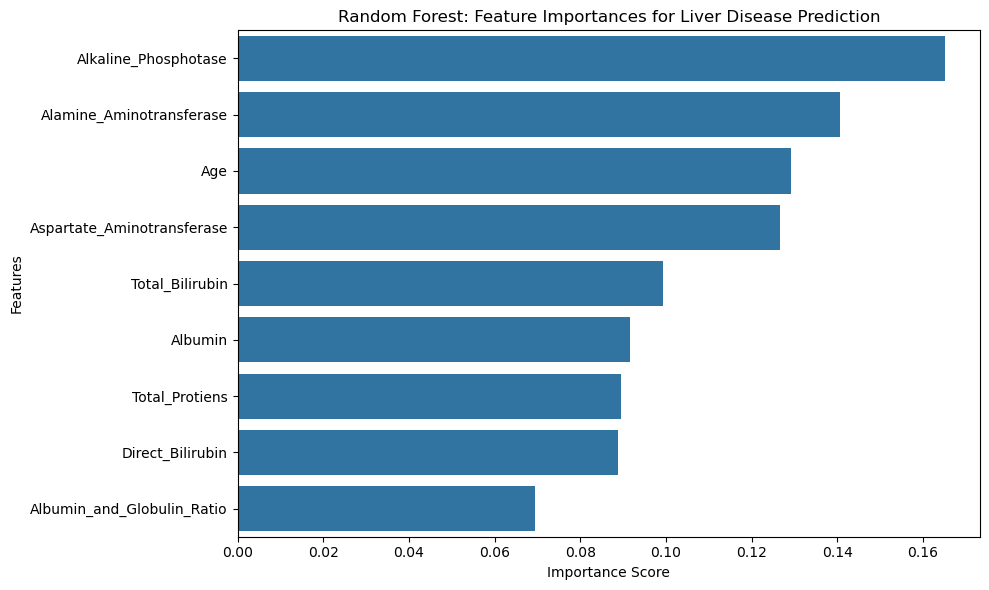

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Random Forest: Feature Importances for Liver Disease Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Classification Ensemble Performance Comparison 

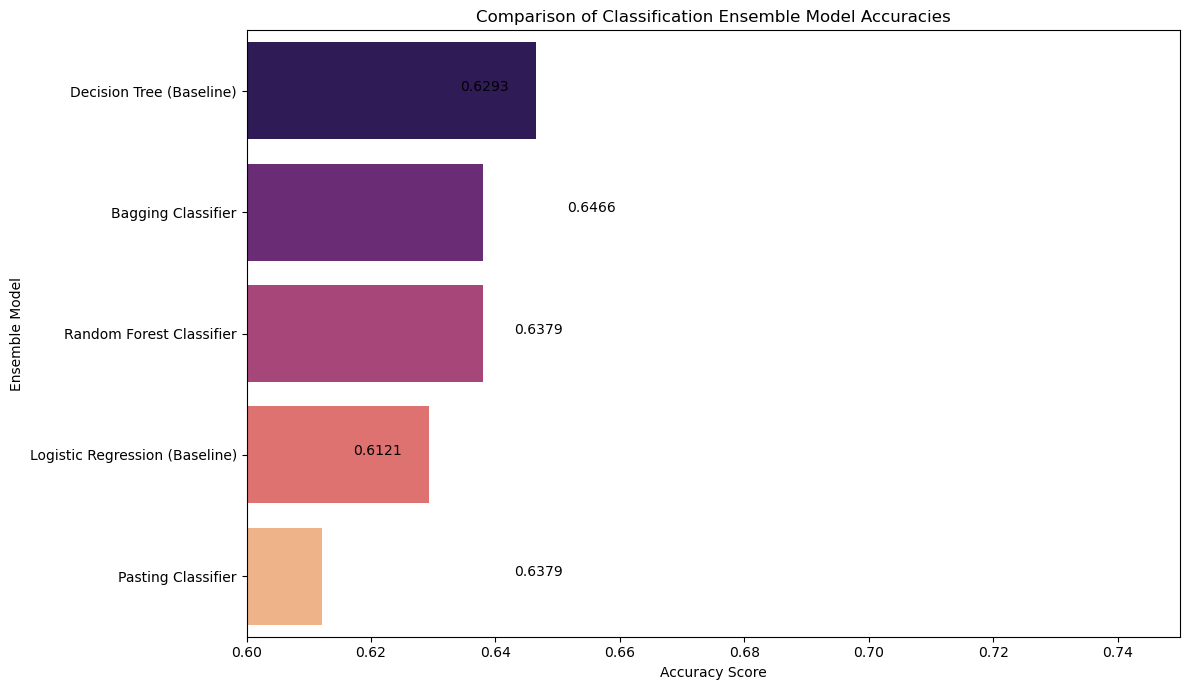

In [14]:
classification_accuracies = {
    "Logistic Regression (Baseline)": accuracy_score(y_test, log_reg.predict(X_test)),
    "Decision Tree (Baseline)": accuracy_score(y_test, tree_clf.predict(X_test)),
    "Bagging Classifier": accuracy_score(y_test, bag_clf.predict(X_test)),
    "Pasting Classifier": accuracy_score(y_test, paste_clf.predict(X_test)),
    "Random Forest Classifier": accuracy_score(y_test, rf_clf.predict(X_test))
}

df_class_acc = pd.DataFrame(classification_accuracies.items(), columns=['Model', 'Accuracy'])
df_class_acc = df_class_acc.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(
    x='Accuracy', 
    y='Model', 
    data=df_class_acc, 
    palette='magma',
    hue='Model',      
    legend=False
)
plt.xlim(0.6, 0.75)
plt.xlabel('Accuracy Score')
plt.ylabel('Ensemble Model')
plt.title('Comparison of Classification Ensemble Model Accuracies')
for index, row in df_class_acc.iterrows():
    plt.text(row.Accuracy + 0.005, index, f'{row.Accuracy:.4f}', color='black', ha="left")
plt.tight_layout()
plt.show()

## Demonstration of Voting Classifiers on Synthetic Data

In [15]:
# Setup Synthetic Data for Voting Classifier Demo ---
X_syn, y_syn = make_classification(
    n_samples=500, n_features=5, n_informative=3, n_redundant=0,
    n_classes=3, n_clusters_per_class=1, random_state=42
)
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(X_syn, y_syn, test_size=0.2, random_state=42)

In [16]:
# Define the models to be used in the ensemble
log_clf_vc = LogisticRegression(random_state=42)
rnd_clf_vc = RandomForestClassifier(random_state=42)
softmax_clf_vc = LogisticRegression(random_state=42)

In [17]:
# Hard Voting
hard_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf_vc), ('rf', rnd_clf_vc), ('sm', softmax_clf_vc)],
    voting='hard'
)
hard_voting_clf.fit(X_train_syn, y_train_syn)
y_pred_hard = hard_voting_clf.predict(X_test_syn)
print(f"\nHard Voting Classifier Accuracy: {accuracy_score(y_test_syn, y_pred_hard):.4f}")


Hard Voting Classifier Accuracy: 0.9400


In [18]:
# Soft Voting 
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf_vc), ('rf', rnd_clf_vc), ('sm', softmax_clf_vc)],
    voting='soft'
)
soft_voting_clf.fit(X_train_syn, y_train_syn)
y_pred_soft = soft_voting_clf.predict(X_test_syn)
print(f"Soft Voting Classifier Accuracy: {accuracy_score(y_test_syn, y_pred_soft):.4f}")

Soft Voting Classifier Accuracy: 0.9500


### Soft Voting (95.00% accuracy) slightly outperformed Hard Voting (94.00% accuracy).

##### This demonstrates a key strength of soft voting: by averaging the prediction probabilities from the base models, it allows a more confident model to have a greater influence. Hard voting, which just takes the majority vote, can sometimes be swayed by multiple less-confident models.

##### The high accuracies for both are because the synthetic make_classification dataset is designed to be well-separated, making it ideal for demonstrating the mechanics of the classifiers.